In [1]:
import os
import logging
from typing import List, Optional
import wandb

import numpy as np
import pandas as pd

import torch

import nll_to_po.models.dn_policy as Policy
from nll_to_po.training.utils import (
    train_single_policy,
    setup_logger,
    set_seed_everywhere,
)
import nll_to_po.training.loss as L
import nll_to_po.training.reward as R

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

logger = logging.getLogger("wandb")
logger.setLevel(logging.ERROR)
os.environ["WANDB_SILENT"] = "true"  # Suppress WandB output

<Figure size 640x480 with 0 Axes>

### config

In [130]:
# Experiment parameters
n_experiments: int = 10
n_updates: int = 100
learning_rate: float = 0.01
use_wandb: bool = False
wandb_project: str = "tractable"

# Policy architecture
input_dim: int = 2
output_dim: int = 2
hidden_sizes: list[int] = [64, 64]
fixed_logstd: bool = False

### Policy model

In [131]:
# policy = Policy.LinearGaussian(input_dim, output_dim, fixed_logstd)
policy = Policy.MLPPolicy(input_dim, output_dim, hidden_sizes, fixed_logstd)

### Data utils

In [132]:
def generate_data_linear(
    input_dim: int,
    output_dim: int,
    train_size: int = 100,
    val_size: int = 100,
    init_dist_loc: Optional[float] = None,
    init_dist_scale: Optional[float] = None,
    A: Optional[torch.Tensor] = None,
):
    assert input_dim == output_dim, "we need square matrices for this application"

    set_seed_everywhere(seed=np.random.randint(0, 1e6))

    # resample parameters
    if not A:
        A = np.random.uniform(0.1, 1.5) * torch.randn(
            (output_dim, input_dim)
        ) + np.random.randint(1, 10)
    if not init_dist_loc:
        init_dist_loc = np.random.uniform(-5.0, 5.0)
    if not init_dist_scale:
        init_dist_scale = np.random.uniform(0.1, 1.5)

    X = np.random.uniform(0.1, 1.5) * torch.randn(
        (train_size + val_size, input_dim)
    ) + np.random.randint(1, 10)
    mean_y = X @ A.T + init_dist_loc
    y = mean_y + torch.randn(train_size + val_size, output_dim) * init_dist_scale
    # X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample

    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=X_train.shape[0], shuffle=True
    )
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=X_val.shape[0], shuffle=False
    )

    return (
        train_dataloader,
        val_dataloader,
        {
            "init_dist_loc": init_dist_loc,
            "init_dist_scale": init_dist_scale,
        },
    )


def generate_data_single_point(
    input_dim: int,
    output_dim: int,
    init_dist_loc: Optional[float] = None,
    init_dist_scale: Optional[float] = None,
    init_dist_n_samples: Optional[int] = None,
):
    set_seed_everywhere(seed=np.random.randint(0, 1e6))

    # resample parameters
    if not init_dist_loc:
        init_dist_loc = np.random.uniform(-5.0, 5.0)
    if not init_dist_scale:
        init_dist_scale = np.random.uniform(0.1, 1.5)
    if not init_dist_n_samples:
        init_dist_n_samples = np.random.randint(1, 100)

    # Generate new random data for each experiment
    X = torch.randn(1, input_dim)
    mean_y = torch.ones((1, output_dim)) * init_dist_loc
    y = mean_y + torch.randn(init_dist_n_samples, output_dim) * init_dist_scale
    X = X.repeat(init_dist_n_samples, 1)  # Repeat X for each sample
    batch_size = X.shape[0]

    # Create a DataLoader
    train_dataset = torch.utils.data.TensorDataset(X, y)
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    return (
        train_dataloader,
        None,
        {
            "init_dist_loc": init_dist_loc,
            "init_dist_scale": init_dist_scale,
            "init_dist_n_samples": init_dist_n_samples,
        },
    )

### Exp function

In [133]:
def run_exp(
    loss_function: L.LossFunction,
    train_dataloader: torch.utils.data.DataLoader,
    val_dataloader: Optional[torch.utils.data.DataLoader] = None,
    config: Optional[dict] = None,
    exp_idx: Optional[int] = 0,
    df_list: List = [],
):
    config["train_size"] = len(train_dataloader)
    if val_dataloader is not None:
        config["val_size"] = len(val_dataloader)
    config["loss_type"] = loss_function.name

    if use_wandb:
        wandb_run = wandb.init(
            project=wandb_project,
            config=config,
        )
    else:
        wandb_run = None
    logger, _, ts_writer = setup_logger(
        logger_name="nll_to_po",
        log_dir="../logs",
        env_id="test_theory",
        exp_name=f"{loss_function.name}_{exp_idx}",
    )
    # Log the configuration
    logger.info(f"%%%%%%%%%%%%%%%%%%%\nconfig:\n{config}\n%%%%%%%%%%%%%%%%%%%%")

    # Run comparison
    _, mse_train_metrics, mse_val_metrics = train_single_policy(
        policy=policy,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        loss_function=loss_function,
        n_updates=n_updates,
        learning_rate=learning_rate,
        wandb_run=wandb_run,
        tensorboard_writer=ts_writer,
        logger=logger,
        early_stopping_patience=100,
    )

    if use_wandb:
        wandb_run.finish()

    # Save to dataframe
    # train
    df = pd.DataFrame(mse_train_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx
    df["train_val"] = "train"
    if "std_0" in df.columns and "std_1" in df.columns:
        df["std_error"] = (
            (
                torch.Tensor(df[["std_0", "std_1"]].values)
                - torch.Tensor([[config["init_dist_scale"], config["init_dist_scale"]]])
            )
            ** 2
        ).sum(dim=-1)
    df_list.append(df)
    # val
    df = pd.DataFrame(mse_val_metrics).reset_index()
    df = df.rename(columns={"index": "epoch"})
    for k, v in config.items():
        df[k] = v
    df["experiment"] = exp_idx
    df["train_val"] = "val"
    if "std_0" in df.columns and "std_1" in df.columns:
        df["std_error"] = (
            (
                torch.Tensor(df[["std_0", "std_1"]].values)
                - torch.Tensor([[config["init_dist_scale"], config["init_dist_scale"]]])
            )
            ** 2
        ).sum(dim=-1)
    df_list.append(df)

### Generate data

In [134]:
df_list: list[pd.DataFrame] = []

In [135]:
# Data generating dist q
single_point: bool = True
generate_new_params_per_exp: bool = False

init_dist_loc: float = 4.0
init_dist_scale: float = 0.75

if single_point:
    init_dist_n_samples: int = 10
    train_dataloader, val_dataloader, data_config = generate_data_single_point(
        input_dim=input_dim,
        output_dim=output_dim,
        init_dist_loc=init_dist_loc,
        init_dist_scale=init_dist_scale,
        init_dist_n_samples=init_dist_n_samples,
    )
else:
    train_size: int = 100
    val_size: int = 100
    A: torch.Tensor = torch.randn((output_dim, input_dim))

    train_dataloader, val_dataloader, data_config = generate_data_linear(
        input_dim=input_dim,
        output_dim=output_dim,
        train_size=train_size,
        val_size=val_size,
        init_dist_loc=init_dist_loc,
        init_dist_scale=init_dist_scale,
        A=A,
    )

### Baselines: MSE & NLL

In [136]:
for loss_function in [L.MSE(), L.NLL()]:
    for exp_idx in range(n_experiments):
        if generate_new_params_per_exp:
            if single_point:
                train_dataloader, val_dataloader, data_config = (
                    generate_data_single_point(
                        input_dim=input_dim,
                        output_dim=output_dim,
                    )
                )
            else:
                train_dataloader, val_dataloader, data_config = generate_data_linear(
                    input_dim=input_dim,
                    output_dim=output_dim,
                    train_size=train_size,
                    val_size=val_size,
                )

        config = {
            "fixed_logstd": fixed_logstd,
            "init_dist_loc": data_config["init_dist_loc"],
            "init_dist_scale": data_config["init_dist_scale"],
            "learning_rate": learning_rate,
        }

        run_exp(
            loss_function=loss_function,
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            config=config,
            exp_idx=exp_idx,
            df_list=df_list,
        )

2025-08-16 22:29:25 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'init_dist_loc': 4.0, 'init_dist_scale': 0.75, 'learning_rate': 0.01, 'train_size': 1, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-16 22:29:25 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 454.01it/s]
2025-08-16 22:29:26 - nll_to_po - INFO - Training completed after 100 epochs
2025-08-16 22:29:26 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'init_dist_loc': 4.0, 'init_dist_scale': 0.75, 'learning_rate': 0.01, 'train_size': 1, 'loss_type': 'MSE'}
%%%%%%%%%%%%%%%%%%%%
2025-08-16 22:29:26 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 607.86it/s]
2025-08-16 22:29:26 - nll_to_po - INFO - Training completed after 100 epochs
2025-08-16 22:29:26 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'init_dist_loc': 4.0, 'init

### PG Entropy Reg

In [137]:
n_generations: int = 5
use_rsample: bool = False
reward_transform: str = "normalize"

for exp_idx in range(n_experiments):
    if generate_new_params_per_exp:
        if single_point:
            train_dataloader, val_dataloader, data_config = generate_data_single_point(
                input_dim=input_dim,
                output_dim=output_dim,
            )
        else:
            train_dataloader, val_dataloader, data_config = generate_data_linear(
                input_dim=input_dim,
                output_dim=output_dim,
                train_size=train_size,
                val_size=val_size,
            )
    for entropy_weight in [0.01, 0.1, 1.0, 10.0]:
        for reward_constant_diagonal in [
            1.0,
            entropy_weight / (data_config["init_dist_scale"] ** 2),
        ]:
            # Define reward function
            reward_fn = R.Mahalanobis(
                matrix=reward_constant_diagonal * torch.eye(output_dim)
            )

            config = {
                "fixed_logstd": fixed_logstd,
                "init_dist_loc": data_config["init_dist_loc"],
                "init_dist_scale": data_config["init_dist_scale"],
                "learning_rate": learning_rate,
                "n_generations": n_generations,
                "use_rsample": use_rsample,
                "reward_transform": reward_transform,
                "entropy_weight": entropy_weight,
                "reward_fn": reward_fn.name,
                "U": r"PG($U=I$)"
                if reward_constant_diagonal == 1.0
                else r"PG($U=\frac{\lambda}{\beta^2}I$)",
            }

            # Define the loss function
            loss_function = L.PG(
                reward_fn=reward_fn,
                n_generations=n_generations,
                use_rsample=use_rsample,
                reward_transform=reward_transform,
                entropy_weight=entropy_weight,
            )
            run_exp(
                loss_function=loss_function,
                train_dataloader=train_dataloader,
                val_dataloader=val_dataloader,
                config=config,
                exp_idx=exp_idx,
                df_list=df_list,
            )

2025-08-16 22:29:29 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'init_dist_loc': 4.0, 'init_dist_scale': 0.75, 'learning_rate': 0.01, 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize', 'entropy_weight': 0.01, 'reward_fn': 'Mahalanobis($I$)', 'U': 'PG($U=I$)', 'train_size': 1, 'loss_type': 'PG(lam=0.01)_Mahalanobis($I$)'}
%%%%%%%%%%%%%%%%%%%%
2025-08-16 22:29:29 - nll_to_po - INFO - Starting training for 100 epochs
Training epochs: 100%|██████████| 100/100 [00:00<00:00, 397.90it/s]
2025-08-16 22:29:30 - nll_to_po - INFO - Training completed after 100 epochs
2025-08-16 22:29:30 - nll_to_po - INFO - %%%%%%%%%%%%%%%%%%%
config:
{'fixed_logstd': False, 'init_dist_loc': 4.0, 'init_dist_scale': 0.75, 'learning_rate': 0.01, 'n_generations': 5, 'use_rsample': False, 'reward_transform': 'normalize', 'entropy_weight': 0.01, 'reward_fn': 'Mahalanobis($\\frac{\\lambda}{\\beta^2}I$)', 'U': 'PG($U=\\frac{\\lambda}{\\beta^2}I$)', 'train_size': 1, 'l

### plot

In [138]:
df_all = pd.concat(df_list, ignore_index=True)
df_all.head(3)

,epoch,mean_error,loss,grad_norm,fixed_logstd,init_dist_loc,init_dist_scale,learning_rate,train_size,loss_type,...,std_0,std_1,std_error,entropy,n_generations,use_rsample,reward_transform,entropy_weight,reward_fn,U
0,0,16.404114,16.404114,12.039743,False,4.0,0.75,0.01,1,MSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,14.709404,14.709404,11.658746,False,4.0,0.75,0.01,1,MSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,13.319903,13.319903,13.703429,False,4.0,0.75,0.01,1,MSE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/tmp/ipykernel_3708951/151798574.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=6, frameon=False)


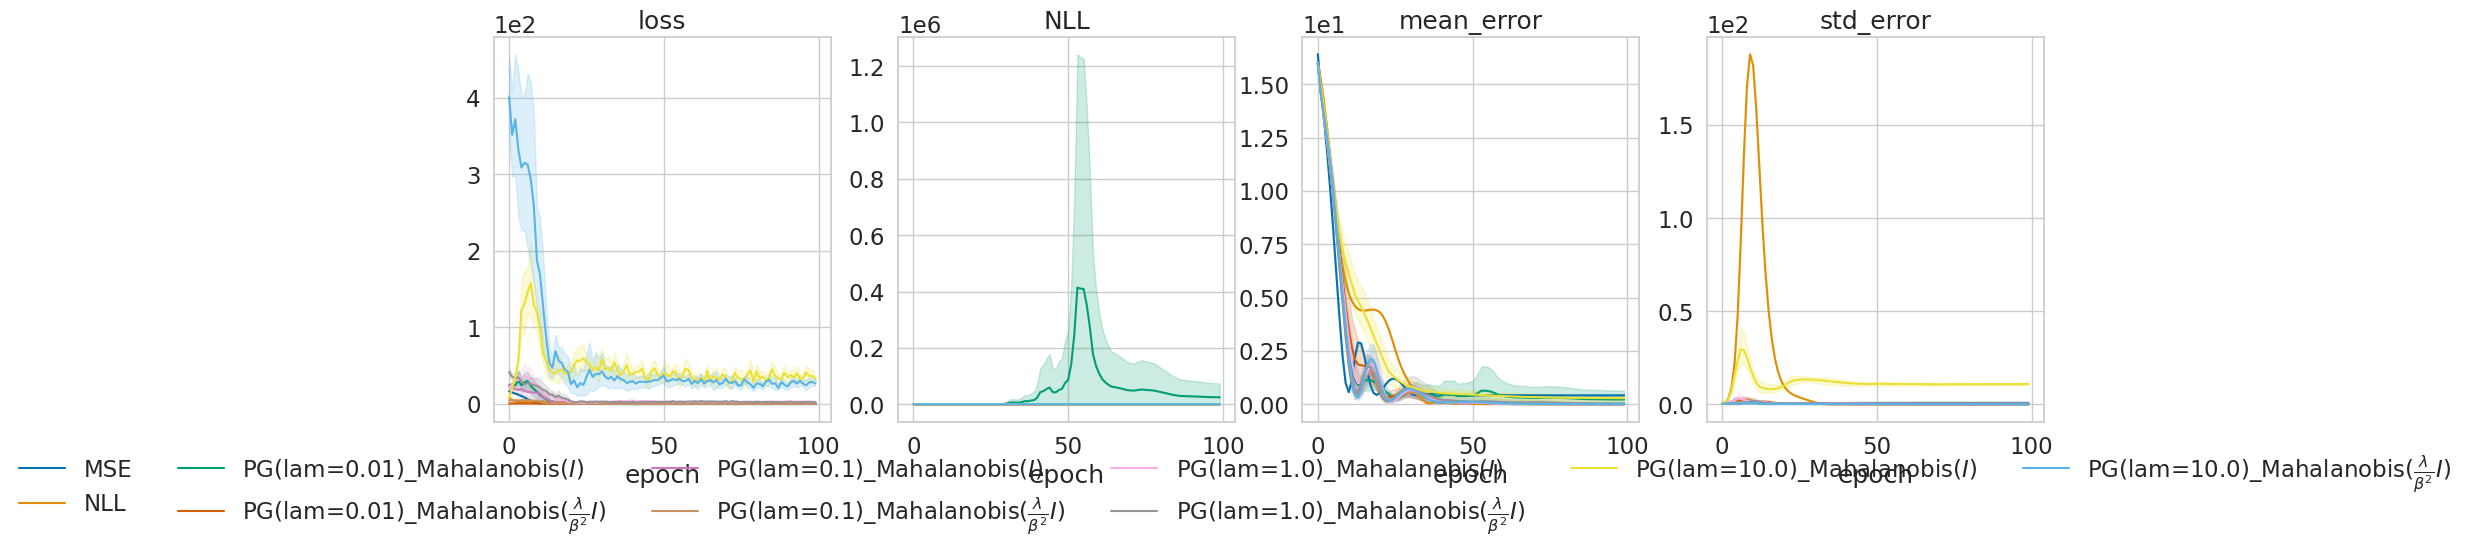

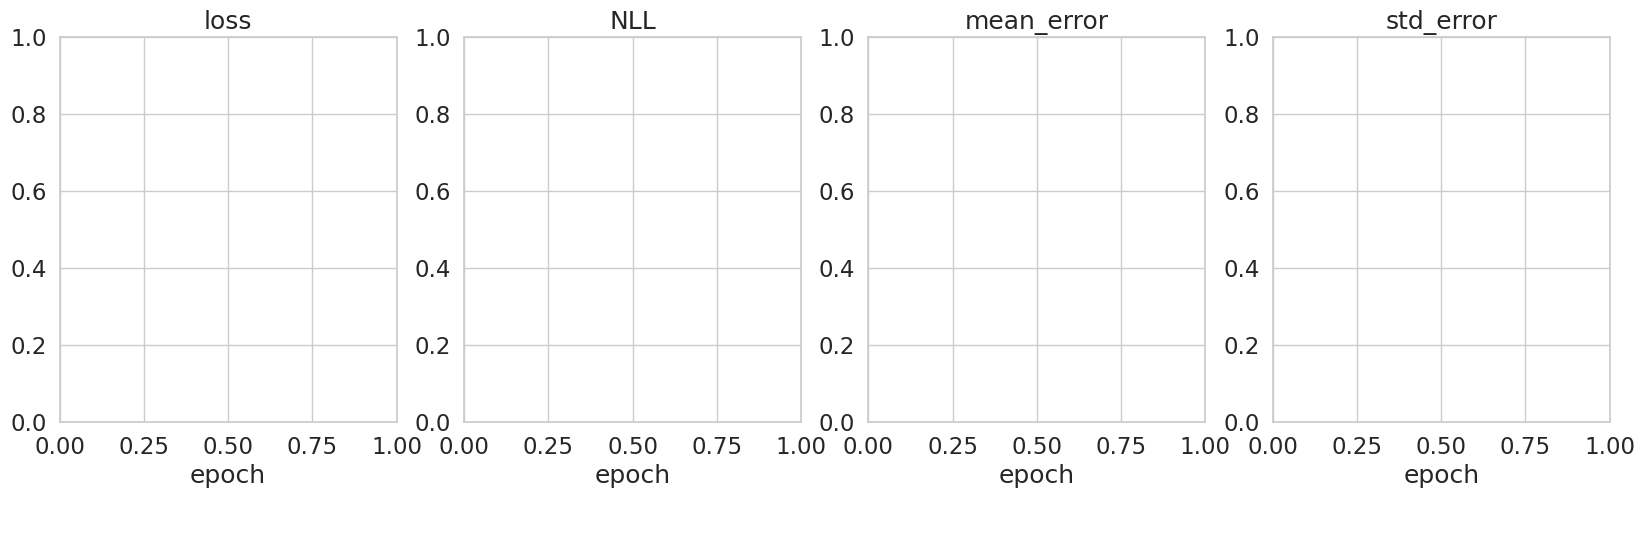

In [139]:
# train
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["loss", "NLL", "mean_error", "std_error"]):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "train"],
        x="epoch",
        y=metric,
        hue="loss_type",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(metric)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=6, frameon=False)

# validation
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i, metric in enumerate(["loss", "NLL", "mean_error", "std_error"]):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "val"],
        x="epoch",
        y=metric,
        hue="loss_type",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(metric)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=6, frameon=False)
plt.show()

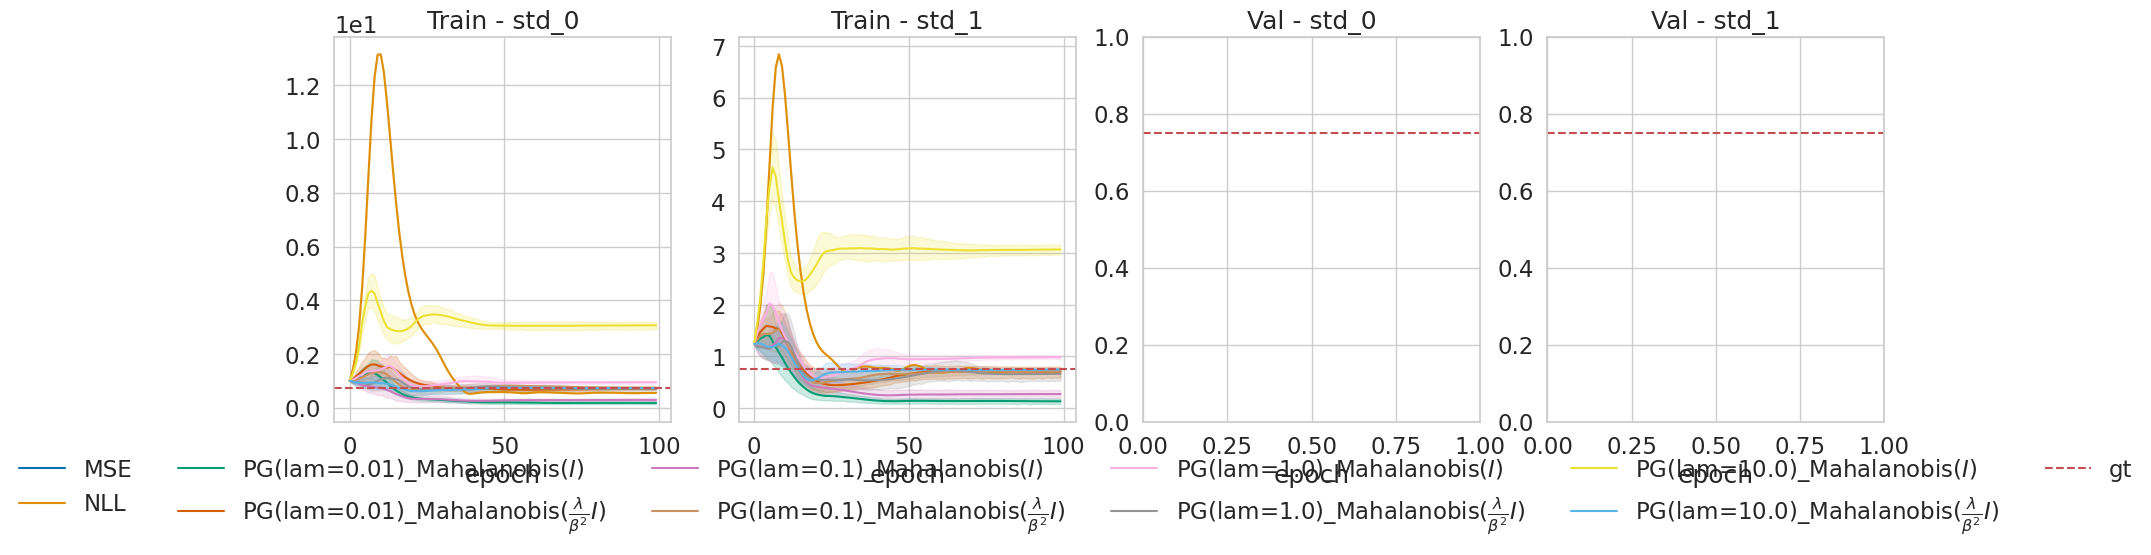

In [140]:
# train
fig, ax = plt.subplots(1, output_dim * 2, figsize=(20, 5))
for i in range(output_dim):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "train"],
        x="epoch",
        y=f"std_{i}",
        hue="loss_type",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(f"Train - std_{i}")
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[i].axhline(y=init_dist_scale, color="r", linestyle="--", label="gt")
for i in range(output_dim):
    sns.lineplot(
        data=df_all[df_all["train_val"] == "val"],
        x="epoch",
        y=f"std_{i}",
        hue="loss_type",
        ax=ax[output_dim + i],
        legend=False,
    )
    ax[output_dim + i].set_ylabel(None)
    ax[output_dim + i].set_title(f"Val - std_{i}")
    ax[output_dim + i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[output_dim + i].axhline(y=init_dist_scale, color="r", linestyle="--")
ax[0].legend(bbox_to_anchor=(2.2, -0.35), loc="lower center", ncol=6, frameon=False)
plt.show()

### ablations

In [141]:
def plot_ablation(
    df: pd.DataFrame,
    hue_variable: str,
    style_variable: Optional[str] = None,
    loss_type_list: List[str] = [],
    use_rsample_list: List[bool] = [],
    n_generations_list: List[int] = [],
    entropy_weight_list: List[float] = [],
    reward_transform_list: List[str] = [],
):
    sub_df = df.copy()
    if loss_type_list:
        sub_df = sub_df[sub_df["loss_type"].isin(loss_type_list)]
    if use_rsample_list:
        sub_df = sub_df[sub_df["use_rsample"].isin(use_rsample_list)]
    if n_generations_list:
        sub_df = sub_df[sub_df["n_generations"].isin(n_generations_list)]
    if entropy_weight_list:
        sub_df = sub_df[sub_df["entropy_weight"].isin(entropy_weight_list)]
    if reward_transform_list:
        sub_df = sub_df[sub_df["reward_transform"].isin(reward_transform_list)]

    sub_df["entropy_weight"] = sub_df["entropy_weight"].astype("str")

    _, ax = plt.subplots(1, 4, figsize=(16, 5))
    for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
        sns.lineplot(
            data=sub_df[sub_df["train_val"] == "train"],
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=4, frameon=False)

    _, ax = plt.subplots(1, 4, figsize=(16, 5))
    for i, metric in enumerate(["loss", "NLL", "mean_error", "grad_norm"]):
        sns.lineplot(
            data=sub_df[sub_df["train_val"] == "val"],
            x="epoch",
            y=metric,
            hue=hue_variable,
            style=style_variable,
            ax=ax[i],
            legend=False if i > 0 else True,
        )
        ax[i].set_ylabel(None)
        ax[i].set_title(metric)
        ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
    ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=6, frameon=False)
    plt.show()

/tmp/ipykernel_3708951/1253589031.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0].legend(bbox_to_anchor=(2.5, -0.55), loc="lower center", ncol=6, frameon=False)


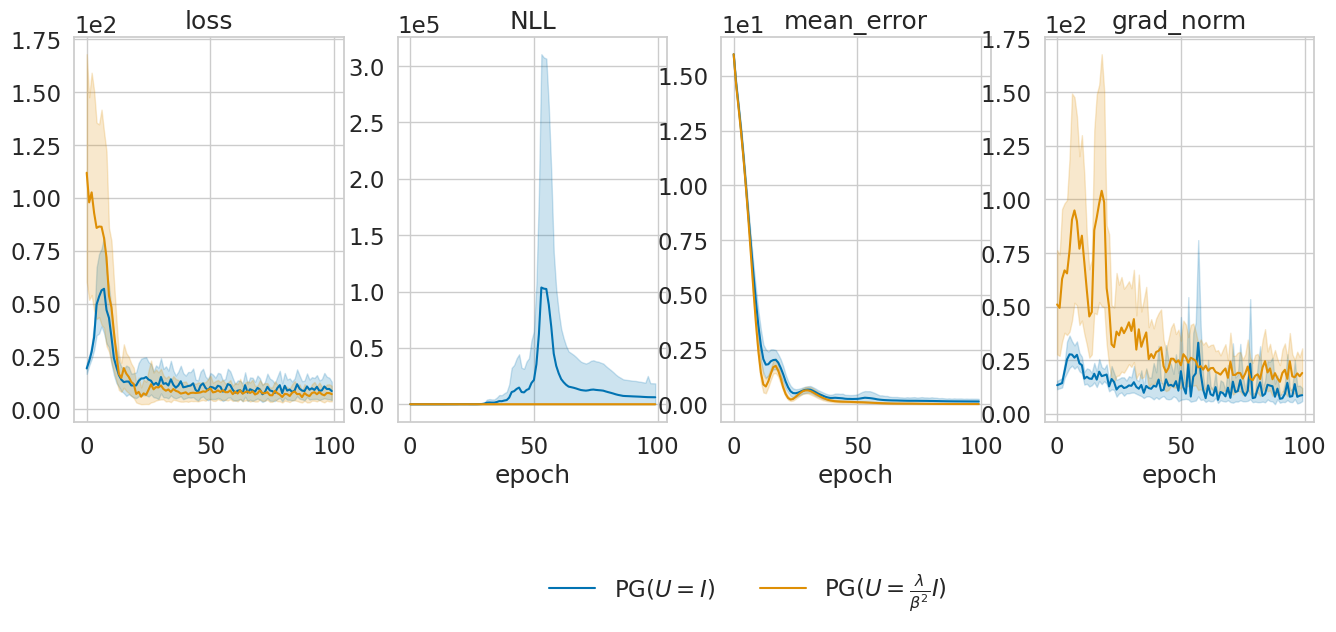

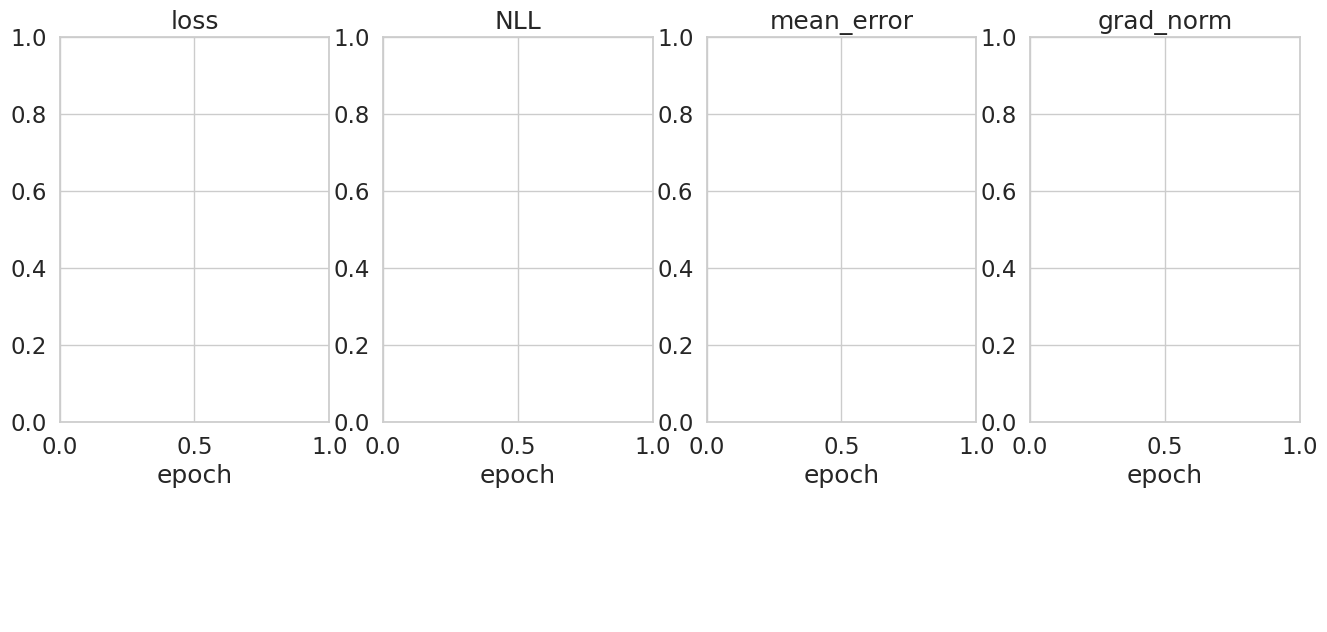

In [142]:
plot_ablation(
    df=df_all,
    hue_variable="U",
    style_variable=None,
    loss_type_list=[],
    use_rsample_list=[],
    n_generations_list=[],
    entropy_weight_list=[],
    reward_transform_list=[],
)

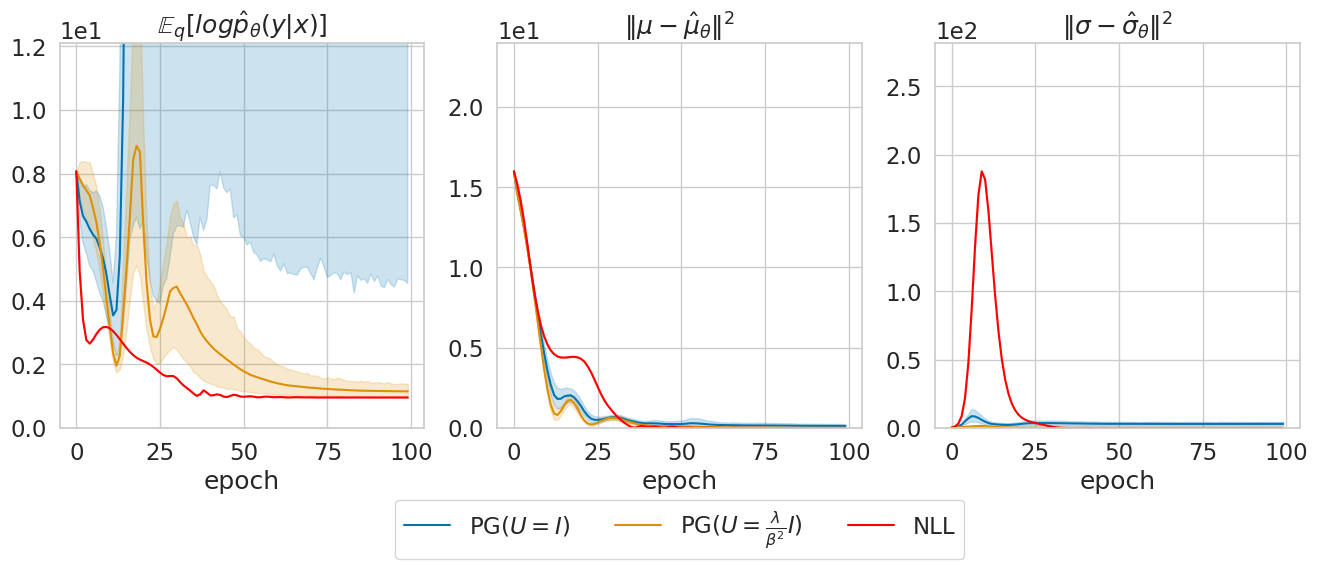

In [143]:
metric = "std_error"

sub_df = df_all.copy()
sub_df["entropy_weight"] = sub_df["entropy_weight"].astype("str")

metric_name = []
metric_name.append(("NLL", r"$\mathbb{E}_q[log\hat{p}_\theta(y|x)]$"))
metric_name.append(("mean_error", r"$\|\mu-\hat{\mu}_\theta\|^2$"))
metric_name.append(("std_error", r"$\|\sigma-\hat{\sigma}_\theta\|^2$"))

_, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, (metric, name) in enumerate(metric_name):
    sns.lineplot(
        data=sub_df[sub_df["train_val"] == "train"].dropna(),
        x="epoch",
        y=metric,
        hue="U",  # "entropy_weight",
        # style="U",
        ax=ax[i],
        legend=False if i > 0 else True,
    )
    sns.lineplot(
        data=sub_df[sub_df["loss_type"] == "NLL"],
        x="epoch",
        y=metric,
        ax=ax[i],
        color="red",
        label="NLL" if i == 0 else None,
    )
    max_for_lim = sub_df[sub_df["loss_type"] == "NLL"][metric].max()
    ax[i].set_ylim(
        min(sub_df[sub_df["loss_type"] == "NLL"][metric].min(), 0.0),
        max_for_lim + max_for_lim / 2,
    )
    ax[i].set_ylabel(None)
    ax[i].set_title(name)
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0, 1))
ax[0].legend(bbox_to_anchor=(1.7, -0.37), loc="lower center", ncol=3)
# ax[0].legend(bbox_to_anchor=(1.73, 1.03))
# plt.savefig("../figures/toy_avg.pdf", bbox_inches="tight")
plt.show()